## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [1]:
!pip uninstall --yes gdown
!pip install gdown -U --no-cache-dir
!gdown 1HZUWDcFP4EJuo76eZ49YZNTVuIn6BZ24 #caption embeddings

Found existing installation: gdown 4.7.3
Uninstalling gdown-4.7.3:
  Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=1HZUWDcFP4EJuo76eZ49YZNTVuIn6BZ24
From (redirected): https://drive.google.com/uc?id=1HZUWDcFP4EJuo76eZ49YZNTVuIn6BZ24&confirm=t&uuid=db1634ad-9bdf-48ce-b51c-f21f5ad22d4a
To: /content/coco_captions.npy
100% 415M/415M [00:06<00:00, 65.6MB/s]


In [2]:
!gdown 1FPvSdUZMf0i57jQ7kfoNNNMh7L2tYitC #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1FPvSdUZMf0i57jQ7kfoNNNMh7L2tYitC
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:01<00:00, 66.5MB/s]


In [3]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW

but Gdown can't. Please check connections and permissions.


In [4]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [5]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [6]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())
coco_dset1 = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json'
                        )

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [7]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [8]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [9]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [10]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


k=1, BLEU Score=0.052238144754208765
k=2, BLEU Score=0.06981125368343964
k=3, BLEU Score=0.07546583946322713
k=4, BLEU Score=0.07843303387064744
k=5, BLEU Score=0.07762775218707005
k=6, BLEU Score=0.077307799649518
k=7, BLEU Score=0.07388262158656615
k=8, BLEU Score=0.06816541067959904
k=9, BLEU Score=0.06580176903835615
k=10, BLEU Score=0.0653691464919633
k=11, BLEU Score=0.07468723592822296
k=12, BLEU Score=0.07599873166974512
k=13, BLEU Score=0.08375781496668752
k=14, BLEU Score=0.08256935638109435
k=15, BLEU Score=0.08462475822924219
k=16, BLEU Score=0.08226407912199338
k=17, BLEU Score=0.08429168341736365
k=18, BLEU Score=0.09180707016994416
k=19, BLEU Score=0.0908328808962893
k=20, BLEU Score=0.09232802330408889
k=21, BLEU Score=0.08951770120544887
k=22, BLEU Score=0.09045343765623987
k=23, BLEU Score=0.09120231591551034
k=24, BLEU Score=0.09250341475136921
k=25, BLEU Score=0.08904084191683104
k=26, BLEU Score=0.09125578975058021
k=27, BLEU Score=0.09016802886957208
k=28, BLEU Sc

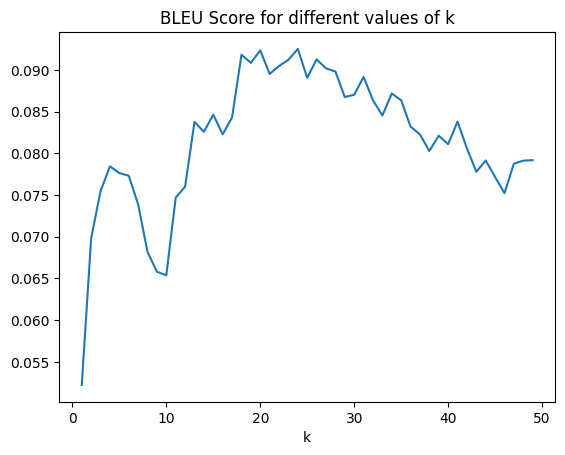

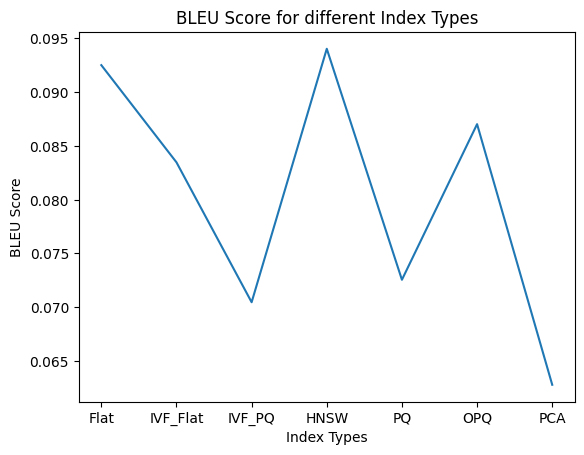

  Index Type  Best BLEU Score
0       Flat         0.092503
1   IVF_Flat         0.083471
2     IVF_PQ         0.070467
3       HNSW         0.094025
4         PQ         0.072555
5        OPQ         0.087019
6        PCA         0.062795
Best Index Type:  PCA


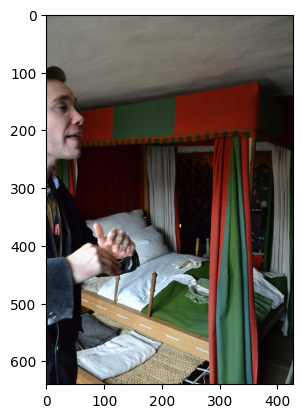

Original Caption:
['A man is standing near a canopy bed.'
 'a man in his bedroom getting ready and a bed well made'
 'A man standing next to a bed while holding his hands together.'
 'A man standing near a bed with a red and green canopy.'
 'a four poster bed covered with red and green curtains behind a man']

Closest Caption:
A man whose head is not pictured stands on his bed


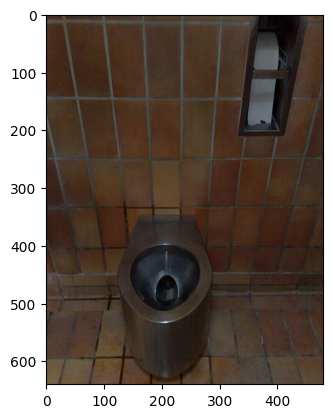

Original Caption:
['a small metallic toilet in a tile bathroom'
 'A picture of a toilet and toilet paper in a bathroom.'
 'A metal toilet bowl against a tiled wall'
 'A brown toilet inside of a public restroom.'
 'A silver toilet that has no movable seat on it.']

Closest Caption:
A white toilet with the lid up in a bathroom.


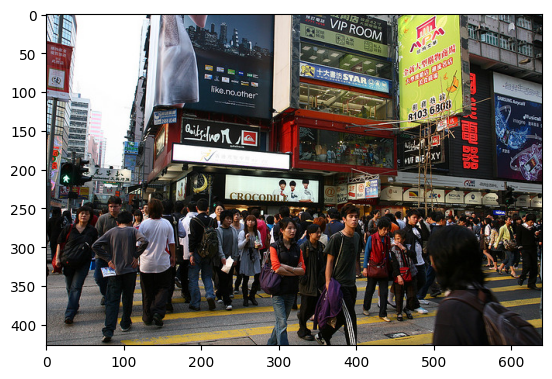

Original Caption:
['A crowd of people walking across a cross walk.'
 'A crowded crosswalk in a city with many store fronts. '
 'THERE ARE A LOT OF PEPOLE THAT ARE WALKING IN THE STREET'
 'There is a large quantity of people crossing the street in the cross walk.'
 'Many pedestrians are walking across the city street.']

Closest Caption:
A crowded city street filled with traffic and pedestrians.


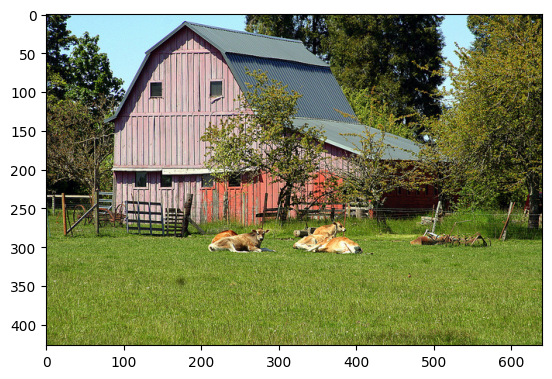

Original Caption:
['A group of cows relaxing in the grass in front of a barn.'
 'This is an image of a barn with several cows in front of it.'
 'The cattle are lying in the green pasture.'
 'A herd of cows laying in  a field by a barn.'
 'horses laying down on the grass beside trees and a barn']

Closest Caption:
The sheep are grazing in a herd in the field.


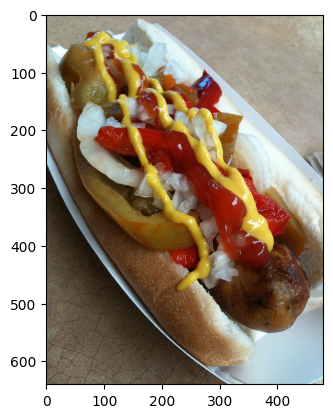

Original Caption:
['a hot dog with mustard, ketchup, and peppers on it'
 'A hot dog is all drizzled with mustard.'
 'a close up of a hot dog with onions'
 'a hot dog with onion ketchup mustard and peppers'
 'A hotdog with ketchup, mustard, and other toppings sitting on a plastic plate']

Closest Caption:
A sandwich sits on a plate on the table. 


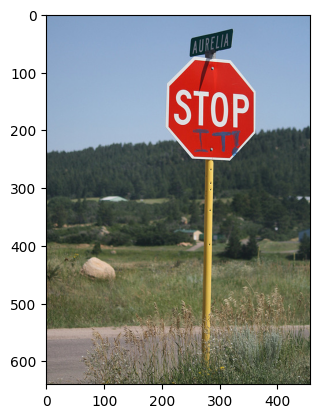

Original Caption:
['A red stop sign next to a road in the middle of nowhere.'
 'A stop sign with "it" written on it.'
 'A stop sign has been spray painted by a vandal'
 'A STOP sign with the word IT written in graffiti after STOP'
 'A picture of a stop sign at an intersection.']

Closest Caption:
A stop sign at the end of a road with a stop sign at the other end.


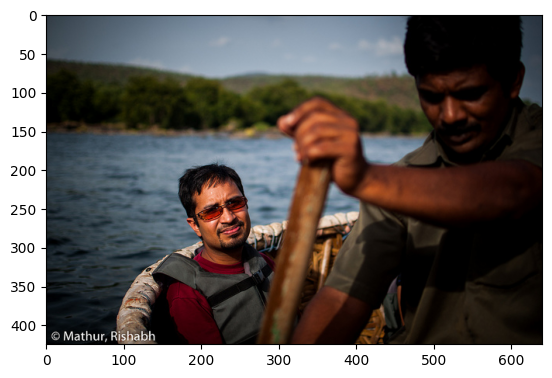

Original Caption:
['A man paddles a boat while his passenger relaxes in the back.'
 'A man rowing a boat with a paddle as another man with a life vest looking on.'
 'A man uses an oar as another man looks on'
 'A couple of people that are in the water.'
 'two males one is rowing some water and trees']

Closest Caption:
A man and a woman paddle a boat down a river.


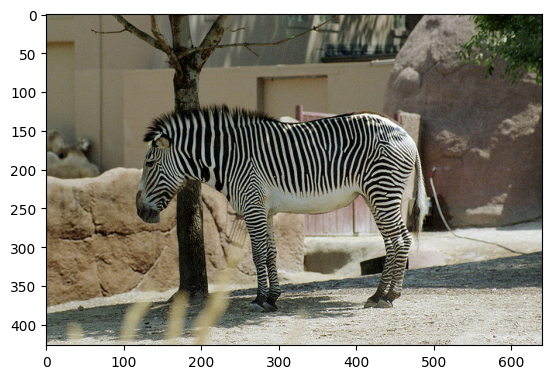

Original Caption:
['And animal that is standing under a tree.'
 'A zebra is standing near a bare tree alone.'
 'A zebra stands next to a tree on gravel.'
 'a white zebra with black stripes (or vice versa)'
 'A striped zebra is in an enclosure by a tree.']

Closest Caption:
A zebra that is focusing on something that is on the ground.


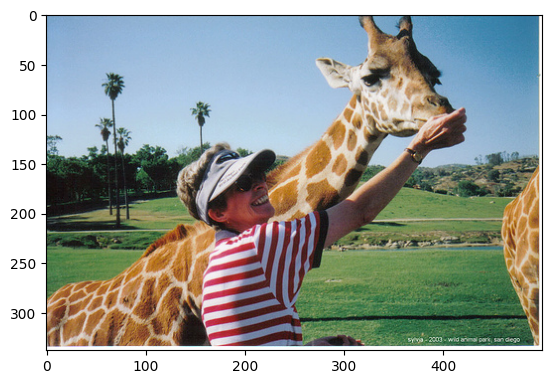

Original Caption:
['A person feeding a giraffe while wearing a hat.'
 'a woman sticking her hand next to a giraffes mouth '
 'A woman feeding a giraffe with her hand. '
 'A person standing next to a large animal>'
 'a women that is feeding some kind of girafffe']

Closest Caption:
A woman standing next to a giraffe and touching its head.


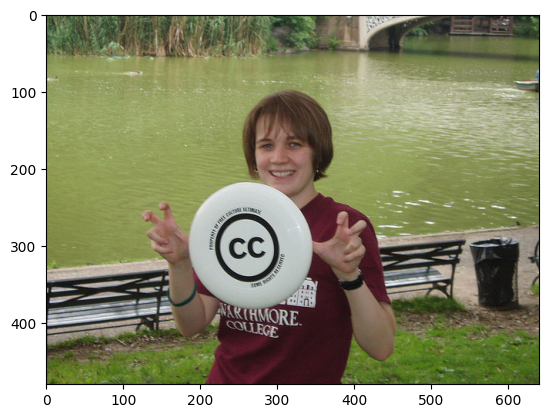

Original Caption:
['A young woman holding a white frisbee in her hands.'
 'a young boy holding a frisby in his thumbs'
 'A woman near a lake holding a frisbee with her thumbs. '
 'A woman is holding a frisbee by a body of water.'
 'A person standing in a grassy area next to a river holding a frisbee.']

Closest Caption:
A man holding his cell phone in front of him in his left hand.  


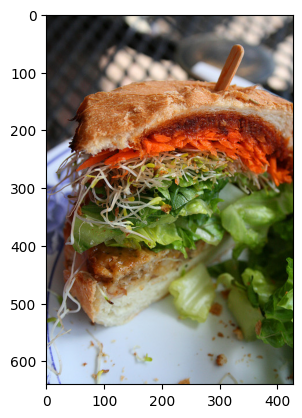

Original Caption:
['A sandwich is shown on top of a plate.'
 'A sandwich is stacked high with healthy veggies.'
 'A veggie sandwich with bean sprouts and shaved carrots, on a plate.'
 'A sandwich that is sitting on a plate on a table.'
 'A sandwich on a dining plate which features sprouts, carrots, and lettuce.']

Closest Caption:
A sandwich that is on a plate with the top piece of bread off.


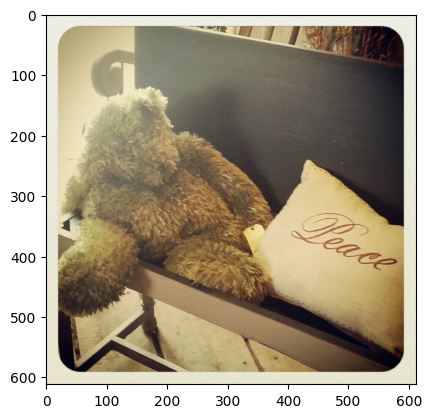

Original Caption:
['a smal bench holds a teddy bear and an embroidered pillow'
 'A stuffed bear is sitting next to a Peace sign pillow. '
 'A teddy bear ad a pillow sitting side by side.'
 'A bear sitting on a bench next to a pillow .'
 'A stuffed teddy bear sits next to a peace pillow.']

Closest Caption:
Two teddy bears are sitting on a couch.


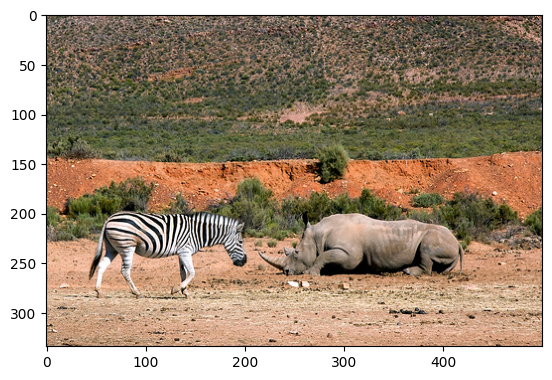

Original Caption:
['A zebra and a rhino interacting in the wild. '
 'The rhinoceros lays down next to the zebra in the safari. '
 'A zebra walking next to a rhino laying down.'
 'Two animals in the middle of a field.'
 'a zebra and a rhino are on some orange dirt']

Closest Caption:
A bunch of zebras standing around in an open field.


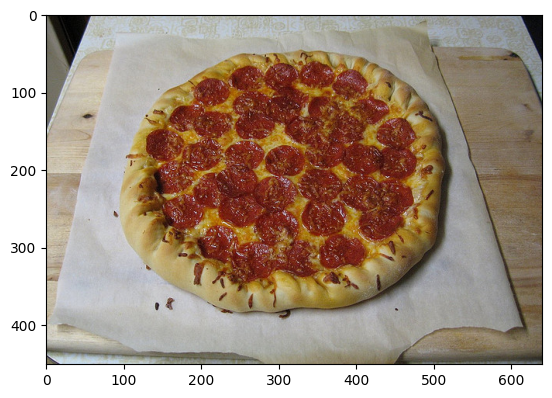

Original Caption:
['A pepperoni pizza sitting on top of a wooden cutting board.'
 'A pizza with pepperoni served on a wooden tray.'
 'A pepperoni pizza on a napkin on top of a wooden surface.'
 'a pepperoni pizza laying on a white piece of parchment paper'
 'A large pepperoni pizza on a cutting board.']

Closest Caption:
A pizza that is sitting on a plate.


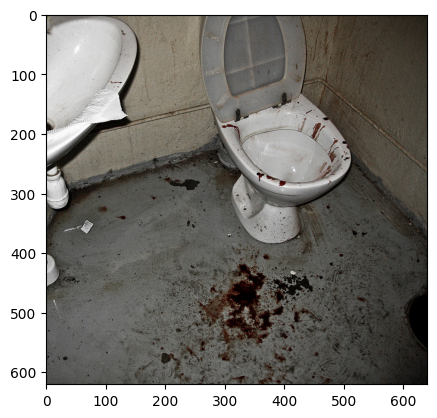

Original Caption:
['A toilet that is covered in some filth, and some filth on the ground.'
 'a bathroom with a toilet that has some blood on it '
 'A toilet with blood on it and on the floor.'
 'A small bathroom with stains on toilet and floor.'
 'A dirty bathroom  with brown liquid on the floor and toilet. ']

Closest Caption:
A dirty toilet that is in a bathroom.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from scipy.spatial.distance import cosine
import faiss

# Assume 'image_embeddings', 'caption_embeddings', 'captions_np', and 'coco_dset1' are defined elsewhere

def calculate_bleu_score(predictions, references):
    '''
    Compute BLEU score as a measurement of accuracy.
    :param predictions: a list of predicted captions
    :param references: a list of actual descriptions
    :return: BLEU accuracy
    '''
    tokenize_and_lowercase = lambda x: x.lower().split()

    accuracy = 0
    smoothing_function = SmoothingFunction().method1

    for i, pred in enumerate(predictions):
        refs = references[i]
        score = sentence_bleu(list(map(lambda ref: tokenize_and_lowercase(ref), refs)),
                              tokenize_and_lowercase(pred),
                              # smoothing_function=smoothing_function
                             )
        accuracy += score
    return accuracy / len(predictions)


class ImageCaptioning:
    def __init__(self, dimensions, index_type):
        '''
        Initialize the ImageCaptioning class with indexing type and dimensionality.
        :param dimensions: The dimensionality of the feature vectors.
        :param index_type: The type of index to use for searching.
        '''
        self.index_type = index_type
        self.d = dimensions

    def search_with_index(self, features, queries, k):
        '''
        Perform a k-nearest-neighbor search on the given features and queries using the specified index type.
        :param features: The feature vectors of the images in the database.
        :param queries: The query vectors.
        :param k: The number of nearest neighbors to retrieve.
        :return: A tuple (D, I) where D contains the distances of the k-nearest neighbors, and I contains the indices of these neighbors in the database.
        '''
        index = None
        q = None

        if self.index_type in ["IVF_Flat", "IVF_PQ"]:
            q = faiss.IndexFlatL2(self.d)
        if self.index_type == "Flat":
            Tmodel = faiss.IndexFlatL2(self.d)
        elif self.index_type == "IVF_Flat":
            Tmodel = faiss.IndexIVFFlat(q, self.d, 100)
        elif self.index_type == "IVF_PQ":
            Tmodel = faiss.IndexIVFPQ(q, self.d, 100, 8, 8)
        elif self.index_type == "HNSW":
            Tmodel = faiss.IndexHNSWFlat(self.d, 32)
        elif self.index_type == "PQ":
            Tmodel = faiss.IndexPQ(self.d, 16, 8)
        elif self.index_type == "OPQ":
            Tmodel = faiss.IndexPreTransform(faiss.OPQMatrix(self.d, 16), faiss.IndexPQ(self.d, 16, 8))
        elif self.index_type == "PCA":
            Tmodel = faiss.IndexPreTransform(faiss.PCAMatrix(self.d, 32, 0.0, True), faiss.IndexFlatL2(32))

        if Tmodel is not None:
            if hasattr(Tmodel, 'is_trained') and not Tmodel.is_trained:
                Tmodel.train(features)
            Tmodel.add(features)
            D, I = Tmodel.search(queries, k)
        return D, I

    def rerank_captions(self, caption_length, query_vector, caption_embeddings, indices, target):
        '''
        Rerank the captions based on cosine similarity between the query vector and caption embeddings, and select the most similar caption.
        :param caption_length: Length of the captions.
        :param query_vector: The query vector for reranking.
        :param caption_embeddings: The embeddings of the captions.
        :param indices: The indices of the top image results from the initial search.
        :param target: The target captions for reranking (unused in the function body, might be for future use).
        :return: The caption that is most similar to the query vector.
        '''
        image_index = -1
        caption_index = -1
        max_similarity = -10
        for index in indices:
            captions = caption_embeddings[index]
            for i in range(0, len(captions)):
                c_similarity = 1 - cosine(query_vector, captions[i])
                if max_similarity < c_similarity:
                    max_similarity = c_similarity
                    image_index = index
                    caption_index = i
        return captions_np[image_index][caption_index]

    def compute_query_vector(self, distances, indices, caption_embeddings, k_neighbors):
        '''
        Compute the query vector for reranking by averaging the caption embeddings of the k-nearest neighbors, weighted by their similarity to the original query.
        :param distances: The distances of the k-nearest neighbors from the original query.
        :param indices: The indices of the k-nearest neighbors in the database.
        :param caption_embeddings: The embeddings of the captions.
        :param k_neighbors: The number of nearest neighbors considered.
        :return: The computed query vector that combines information from the k-nearest neighbors.
        '''
        similarities = 1 / (1 + distances[0])
        nearest_caption_embeddings = caption_embeddings[indices[0], :, :]
        weighted_sum = np.sum(nearest_caption_embeddings * similarities[:, np.newaxis, np.newaxis], axis=(0, 1))
        query_vector = weighted_sum / (k_neighbors * 5)
        return query_vector


# Driver Code
# Set parameters
training_limit = 40000
testing_start = 40001
features = np.array(image_embeddings[:training_limit])
queries = np.array(image_embeddings[testing_start:])

# Constants
dimensions = 512
results = {}
max_bleu_score = -1
best_k = -1
model = ImageCaptioning(dimensions, "Flat")

# Main loop
for k_value in range(1, 50):
    actual_captions = []
    predicted_captions = []
    distances, indices = model.search_with_index(features, queries, k_value)
    for i_value in range(testing_start, 40504):
        query = model.compute_query_vector(distances[i_value - testing_start:], indices[i_value - testing_start:], caption_embeddings, k_value)
        closest_captions = model.rerank_captions(i_value, query, caption_embeddings, indices[i_value - testing_start], captions_np)
        actual_captions.append(captions_np[i_value])
        predicted_captions.append(closest_captions)

    bleu_score = calculate_bleu_score(predicted_captions, actual_captions)
    results[k_value] = bleu_score
    print(f'k={k_value}, BLEU Score={bleu_score}')
    if max_bleu_score < bleu_score:
        best_k = k_value
        max_bleu_score = bleu_score

# Continue with the rest of the code...

# Continue with the rest of the code...

print("best k: ", best_k)
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel('k')
plt.ylabel
# Continue with the rest of the code...

# Plot BLEU Scores for different values of k
plt.title('BLEU Score for different values of k')
plt.show()

# Define index types for comparison
index_types = [
    "Flat",        # Brute-force search
    "IVF_Flat",    # Inverted File index with Flat sub-index
    "IVF_PQ",      # Inverted File index with Product Quantization sub-index
    "HNSW",        # Hierarchical Navigable Small World index
    "PQ",          # Product Quantization index
    "OPQ",         # Optimized Product Quantization
    "PCA"          # Principal Component Analysis-based index
]

# Compare BLEU Scores for different index types
comparison_results = {}
best_index_type = ""
for index_type in index_types:
    actual_captions = []
    predicted_captions = []
    max_bleu_score = -100
    model = ImageCaptioning(dimensions, index_type)
    distances, indices = model.search_with_index(features, queries, best_k)
    for i_value in range(testing_start, 40504):
        query = model.compute_query_vector(distances[i_value - testing_start:], indices[i_value - testing_start:], caption_embeddings, best_k)
        closest_captions = model.rerank_captions(i_value, query, caption_embeddings, indices[i_value - testing_start], captions_np)
        actual_captions.append(captions_np[i_value])
        predicted_captions.append(closest_captions)

    bleu_score = calculate_bleu_score(predicted_captions, actual_captions)
    if bleu_score > max_bleu_score:
        max_bleu_score = bleu_score
        best_index_type = index_type
    comparison_results[index_type] = max_bleu_score

# Plot BLEU Scores for different index types
plt.plot(list(comparison_results.keys()), list(comparison_results.values()))
plt.xlabel('Index Types')
plt.ylabel('BLEU Score')
plt.title('BLEU Score for different Index Types')
plt.show()

# Display comparison results in a DataFrame
df_comparison = pd.DataFrame(list(comparison_results.items()), columns=['Index Type', 'Best BLEU Score'])
print(df_comparison)

print("Best Index Type: ", best_index_type)

# Initialize the best model with the optimal parameters
best_model = ImageCaptioning(512, best_index_type)
distances, indices = best_model.search_with_index(features, queries, best_k)

# Display results for a few test images
for i_value in range(testing_start + 50, testing_start + 65):
    query = best_model.compute_query_vector(distances[i_value - testing_start:], indices[i_value - testing_start:], caption_embeddings, best_k)
    closest_captions = best_model.rerank_captions(i_value, query, caption_embeddings, indices[i_value - testing_start], captions_np)
    img1, target1 = coco_dset1[i_value]

    plt.imshow(img1)
    plt.show()

    original_caption = captions_np[i_value]

    print("Original Caption:")
    print(original_caption)

    print("\nClosest Caption:")
    print(closest_captions)

    print("=" * 80)
